# Tutorial: MLP

## Step 1: Load the Adult Dataset

In [5]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame
df.head()

/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


## Step 2: Preprocess the Dataset

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Drop rows with missing values
df = df.replace('?', pd.NA).dropna()

# Encode categorical variables
df_encoded = df.copy()
le = LabelEncoder()
for col in df_encoded.select_dtypes(include='category').columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Split features and labels
X = df_encoded.drop('class', axis=1)
y = le.fit_transform(df_encoded['class'])

# Train-val-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Further split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Step 3: Define Model

In [7]:
import torch.nn as nn

# Simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

## Step 4: Train Model

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model
model = SimpleNN(X_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

train_losses = []
val_losses = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    total_batches = 0

    for xb, yb in dataloader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        total_batches += 1

    avg_train_loss = epoch_train_loss / total_batches

    model.eval()
    with torch.no_grad():
        val_X_tensor = torch.tensor(X_val, dtype=torch.float32)
        val_y_tensor = torch.tensor(y_val, dtype=torch.long)
        val_logits = model(val_X_tensor)
        val_loss = criterion(val_logits, val_y_tensor)
        _, val_preds = torch.max(val_logits, 1)
        val_accuracy = (val_preds == val_y_tensor).float().mean()

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy.item():.4f}')
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss.item())



Epoch 1/10, Train Loss: 0.4173, Validation Loss: 0.3541, Validation Accuracy: 0.8350
Epoch 2/10, Train Loss: 0.3395, Validation Loss: 0.3342, Validation Accuracy: 0.8439
Epoch 3/10, Train Loss: 0.3326, Validation Loss: 0.3329, Validation Accuracy: 0.8454
Epoch 4/10, Train Loss: 0.3308, Validation Loss: 0.3314, Validation Accuracy: 0.8461
Epoch 5/10, Train Loss: 0.3294, Validation Loss: 0.3294, Validation Accuracy: 0.8445
Epoch 6/10, Train Loss: 0.3290, Validation Loss: 0.3282, Validation Accuracy: 0.8492
Epoch 7/10, Train Loss: 0.3281, Validation Loss: 0.3277, Validation Accuracy: 0.8461
Epoch 8/10, Train Loss: 0.3275, Validation Loss: 0.3280, Validation Accuracy: 0.8467
Epoch 9/10, Train Loss: 0.3270, Validation Loss: 0.3270, Validation Accuracy: 0.8470
Epoch 10/10, Train Loss: 0.3266, Validation Loss: 0.3272, Validation Accuracy: 0.8454


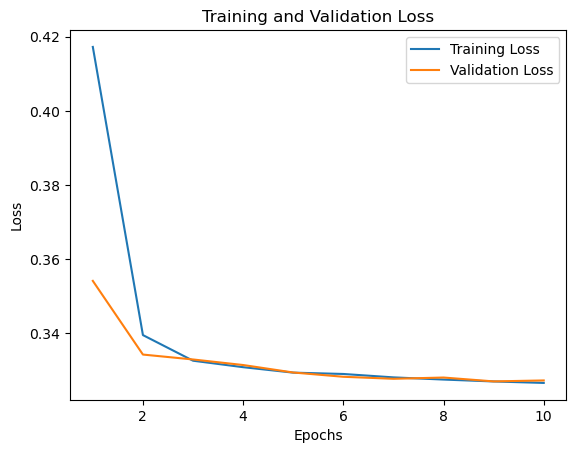

In [17]:
# Plot training and validation loss
import matplotlib.pyplot as plt
# Assuming you have lists to store losses
# Example of how to plot losses
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [18]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_X_tensor = torch.tensor(X_test, dtype=torch.float32)
    test_y_tensor = torch.tensor(y_test, dtype=torch.long)
    test_logits = model(test_X_tensor)
    test_loss = criterion(test_logits, test_y_tensor)
    _, test_preds = torch.max(test_logits, 1)
    test_accuracy = (test_preds == test_y_tensor).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy.item():.4f}')

Test Loss: 0.3373, Test Accuracy: 0.8419


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# Initialize the model
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')

# Train the model
logreg.fit(X_train, y_train)

# Predict on validation set
test_probs = logreg.predict_proba(X_test)
test_preds = logreg.predict(X_test)

# Compute validation log-loss and accuracy
test_log_loss = log_loss(y_test, test_probs)
test_accuracy = accuracy_score(y_val, val_preds)

print(f'Test Log Loss: {test_log_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Log Loss: 0.3910
Test Accuracy: 0.8173
